In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and Overview

In [58]:
data = pd.read_csv("../data/synthetic/ab_test_fintech_data.csv")

In [34]:
data.head()

,user_id,group,converted,timestamp,clicks,views
0,1,control,0,2025-01-01 00:00:00,2,3
1,2,test,0,2025-01-01 00:01:00,3,5
2,3,control,0,2025-01-01 00:02:00,6,8
3,4,control,0,2025-01-01 00:03:00,1,3
4,5,control,0,2025-01-01 00:04:00,4,4


In [35]:
data.shape

(1000, 6)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    1000 non-null   int64 
 1   group      1000 non-null   object
 2   converted  1000 non-null   int64 
 3   timestamp  1000 non-null   object
 4   clicks     1000 non-null   int64 
 5   views      1000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 47.0+ KB


In [37]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1000.0,500.500,288.819436,1.0,250.75,500.5,750.25,1000.0
converted,1000.0,0.139,0.346120,0.0,0.00,0.0,0.00,1.0
clicks,1000.0,2.957,1.672109,0.0,2.00,3.0,4.00,9.0
views,1000.0,3.929,1.856719,0.0,3.00,4.0,5.00,10.0


# Preparation

In [38]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Plot

In [39]:
sns.set(style="whitegrid")

In [40]:
conversion_rates = data.groupby('group')['converted'].mean().reset_index()

/tmp/ipykernel_48451/2375002853.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group', y='converted', data=conversion_rates, palette='Set2')


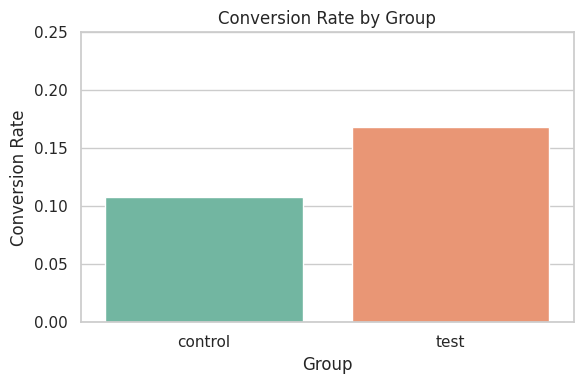

In [41]:
plt.figure(figsize=(6, 4))
sns.barplot(x='group', y='converted', data=conversion_rates, palette='Set2')
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.ylim(0, 0.25)
plt.tight_layout()
plt.show()


/tmp/ipykernel_48451/3516855736.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='clicks', data=data, palette='Pastel1')


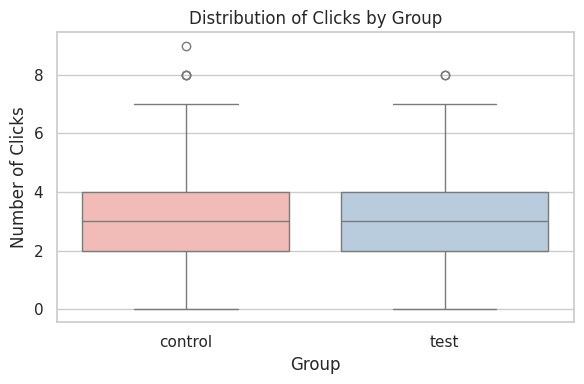

In [42]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='group', y='clicks', data=data, palette='Pastel1')
plt.title('Distribution of Clicks by Group')
plt.ylabel('Number of Clicks')
plt.xlabel('Group')
plt.tight_layout()
plt.show()


/tmp/ipykernel_48451/1304641707.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='views', data=data, palette='coolwarm')


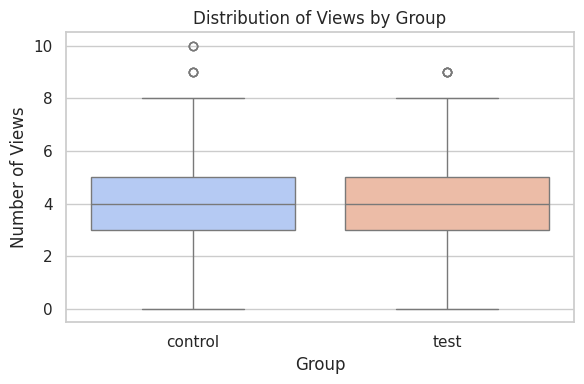

In [43]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='group', y='views', data=data, palette='coolwarm')
plt.title('Distribution of Views by Group')
plt.ylabel('Number of Views')
plt.xlabel('Group')
plt.tight_layout()
plt.show()


/tmp/ipykernel_48451/1860582580.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_series = data.resample('H').sum()[['clicks', 'views']]


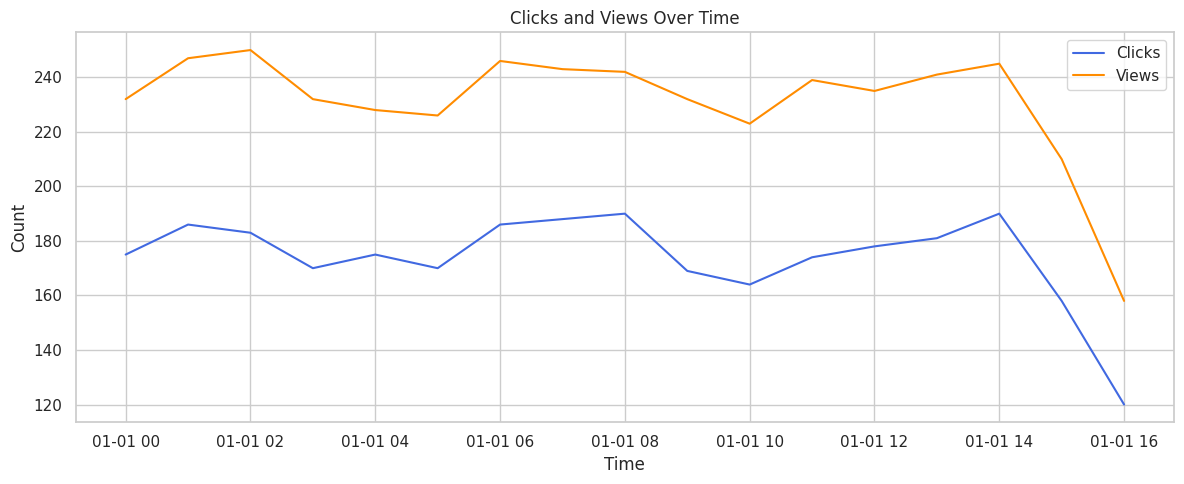

In [44]:
data.set_index('timestamp', inplace=True)
time_series = data.resample('H').sum()[['clicks', 'views']] 

plt.figure(figsize=(12, 5))
plt.plot(time_series.index, time_series['clicks'], label='Clicks', color='royalblue')
plt.plot(time_series.index, time_series['views'], label='Views', color='darkorange')
plt.title('Clicks and Views Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


<Axes: xlabel='group', ylabel='converted'>

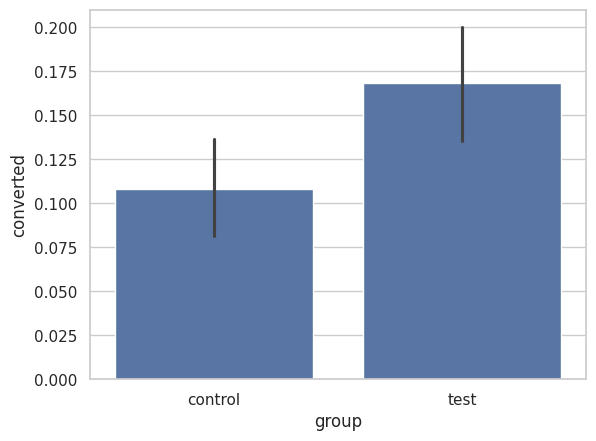

In [46]:
sns.barplot(x='group', y='converted', data=data)


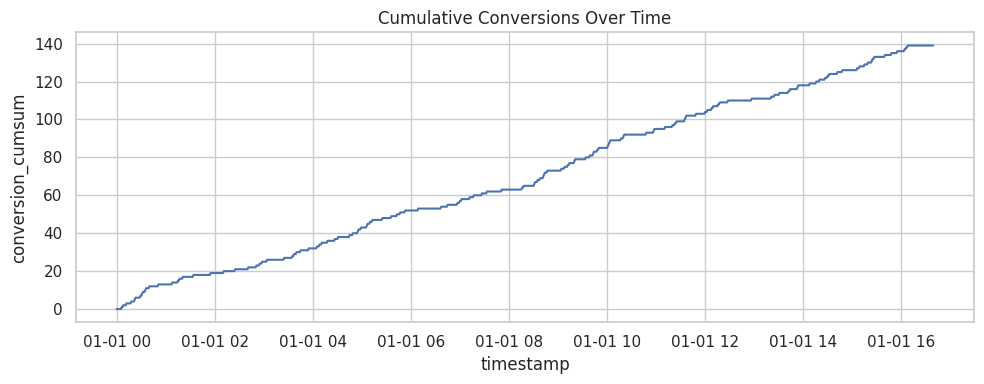

In [47]:
data['conversion_cumsum'] = data['converted'].cumsum()

plt.figure(figsize=(10, 4))
sns.lineplot(data=data, x='timestamp', y='conversion_cumsum')
plt.title('Cumulative Conversions Over Time')
plt.tight_layout()
plt.show()


<Axes: xlabel='timestamp', ylabel='conversion_group_cumsum'>

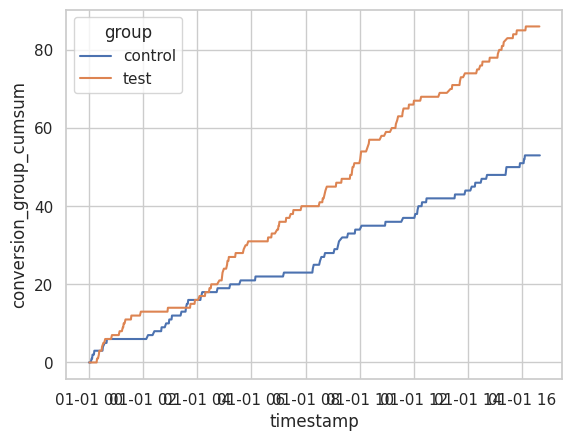

In [50]:
data['conversion_group_cumsum'] = data.groupby('group')['converted'].cumsum()
sns.lineplot(data=data, x='timestamp', y='conversion_group_cumsum', hue='group')


/tmp/ipykernel_48451/2227510725.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(funnel.keys()), y=list(funnel.values()), palette='Blues_r')


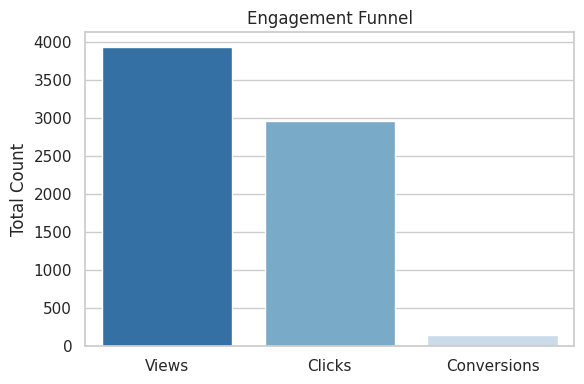

In [51]:
funnel = {
    'Views': data['views'].sum(),
    'Clicks': data['clicks'].sum(),
    'Conversions': data['converted'].sum()
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(funnel.keys()), y=list(funnel.values()), palette='Blues_r')
plt.title('Engagement Funnel')
plt.ylabel('Total Count')
plt.tight_layout()
plt.show()


/tmp/ipykernel_48451/1738169305.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_by_clicks = data.groupby('click_bins')['converted'].mean().reset_index()


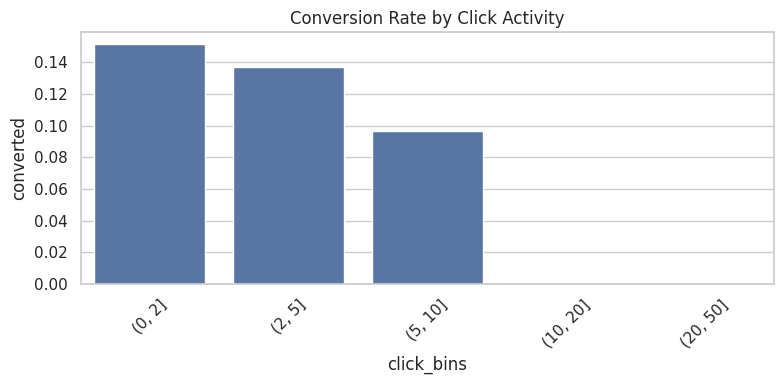

In [52]:
data['click_bins'] = pd.cut(data['clicks'], bins=[0, 2, 5, 10, 20, 50])
conversion_by_clicks = data.groupby('click_bins')['converted'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='click_bins', y='converted', data=conversion_by_clicks)
plt.title('Conversion Rate by Click Activity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Clicks Distribution by Group')

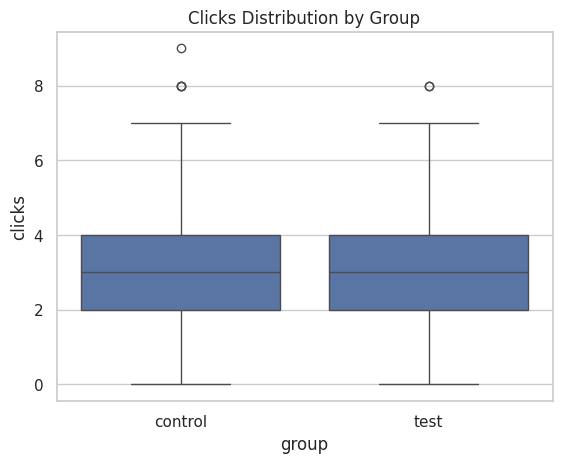

In [54]:
sns.boxplot(x='group', y='clicks', data=data)
plt.title('Clicks Distribution by Group')


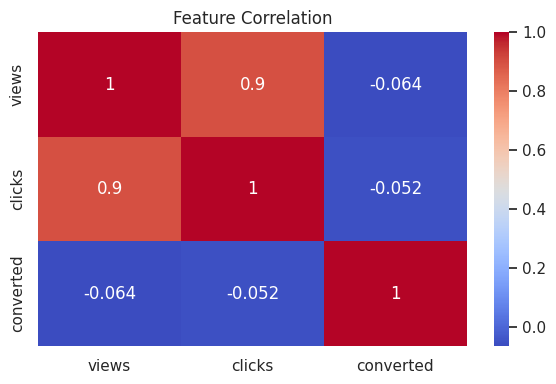

In [55]:
plt.figure(figsize=(6, 4))
sns.heatmap(data[['views', 'clicks', 'converted']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.tight_layout()
plt.show()


In [57]:
import plotly.express as px
px.histogram(data, x='clicks', color='group', nbins=20, title='Clicks Distribution by Group')


# Analysis Pipeline